In [25]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Exercise 07 : Heatmap

In [26]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

In [27]:
query = """
SELECT 
    uid,
    CASE strftime('%w', timestamp)
        WHEN '0' THEN 'Sun' WHEN '1' THEN 'Mon' WHEN '2' THEN 'Tue'
        WHEN '3' THEN 'Wed' WHEN '4' THEN 'Thu' WHEN '5' THEN 'Fri'
        ELSE 'Sat' END as weekday,
    COUNT(*) as commit_count
FROM checker 
WHERE uid LIKE 'user_%'
GROUP BY uid, weekday
"""

df_weekdays = pd.read_sql(query, con=conn)

result_df_week = (df_weekdays.pivot(index='uid', columns='weekday', values='commit_count')
                  .fillna(0)
                  .reindex(columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
                  .loc[df_weekdays.groupby('uid')['commit_count'].sum().sort_values(ascending=False).index])
result_df_week = result_df_week.T

query = """
SELECT 
    uid,
    CAST(strftime('%H', timestamp) AS INTEGER) as hour,
    COUNT(*) as commit_count
FROM checker 
WHERE uid LIKE 'user_%'
GROUP BY uid, hour
"""

df_hours = pd.read_sql(query, con=conn)
conn.close()

result_df_hours = (df_hours.pivot(index='uid', columns='hour', values='commit_count').fillna(0)
                             .reindex(columns=range(24), fill_value=0)
                             .loc[df_hours.groupby('uid')['commit_count'].sum().sort_values(ascending=False).index]
                             .T)

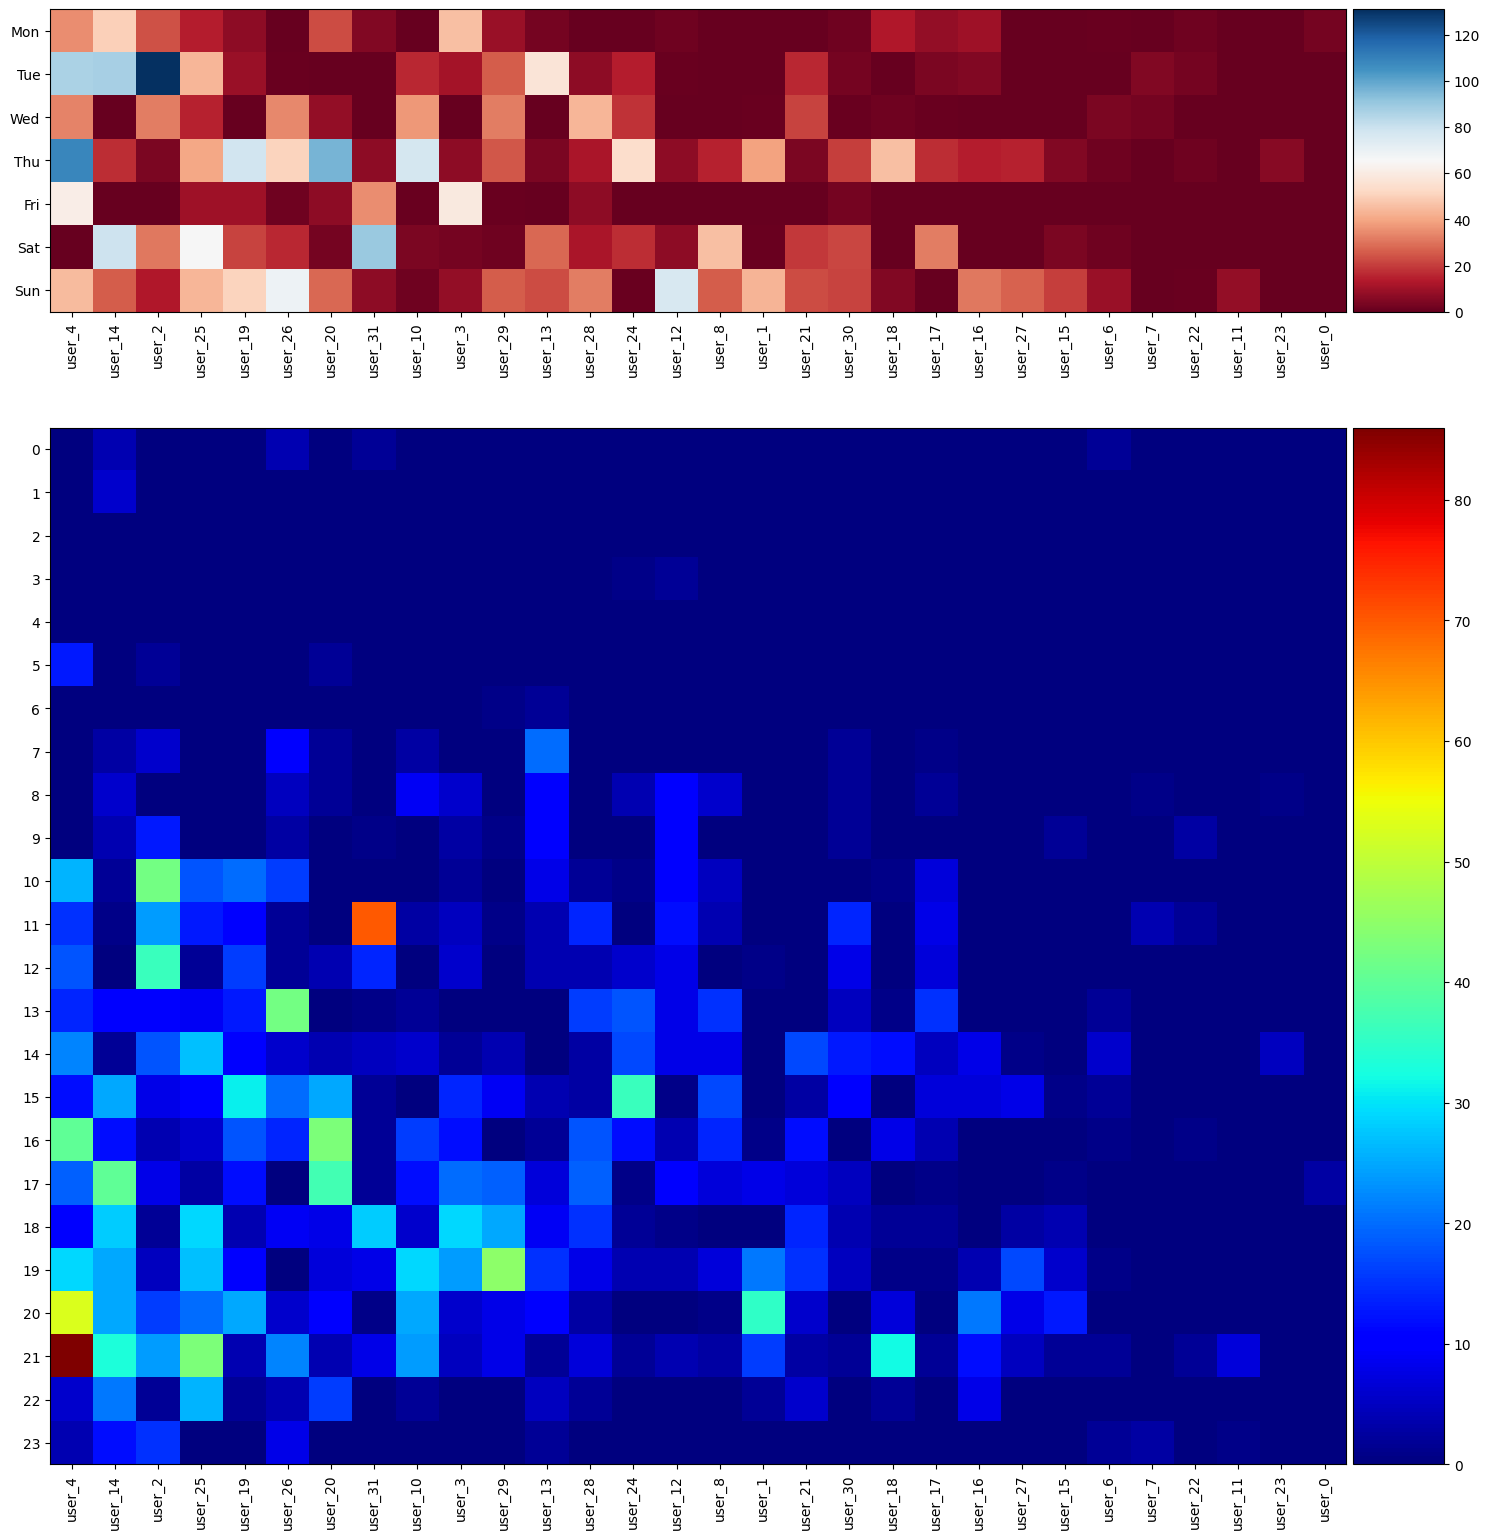

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(15, 16), gridspec_kw={'height_ratios': [1, 3]})

p1 = axs[0].imshow(result_df_week, cmap='RdBu', aspect='equal')
axs[0].set_xticks(range(len(result_df_week.columns)))
axs[0].set_xticklabels(result_df_week.columns, rotation=90)
axs[0].set_yticks(range(len(result_df_week.index)))
axs[0].set_yticklabels(result_df_week.index)

ax0_divider = make_axes_locatable(axs[0])
cax0 = ax0_divider.append_axes("right", size="7%", pad=0.07)
plt.colorbar(p1, cax=cax0)

p2 = axs[1].imshow(result_df_hours, cmap='jet', aspect='equal')
axs[1].set_xticks(range(len(result_df_hours.columns)))
axs[1].set_xticklabels(result_df_hours.columns, rotation=90)
axs[1].set_yticks(range(len(result_df_hours.index)))
axs[1].set_yticklabels(result_df_hours.index)

ax1_divider = make_axes_locatable(axs[1])
cax1 = ax1_divider.append_axes("right", size="7%", pad=0.07)
plt.colorbar(p2, cax=cax1)

plt.tight_layout()
plt.show()

Which user has the most commits on Tue? user_2

Which user has the most commits on Thu? user_4

On which weekday do the users not like making a lot of commits? Fri

Which user at which hour made the largest number of commits? user_4, 21